In [1]:
from __future__ import print_function
import astropy
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#sys.path.pop(0)
%matplotlib inline

# First, lets make sure that barycorrpy is working

In [2]:
import barycorrpy
barycorrpy.__version__ #This tutorial assumes v0.4.4

'0.4.4'

In [3]:
# Running sample script - this should print:
# """
# ***********SUCCESS**************
# All barycentric correction velocities,  and time stamp conversions match expected values.
# """
from barycorrpy import sample_script 
results = sample_script.run_sample() 

Please join our Google Group to keep abreast of the latest versions and bug fixes - https://groups.google.com/g/barycorrpy
***********SUCCESS**************
All barycentric correction velocities,  and time stamp conversions match expected values.


# Import our package

In [6]:
import hpfspec
hpfspec

<module 'hpfspec' from '/home/tehan/PycharmProjects/neidspec/hpfspec/__init__.py'>

In [7]:
# Lets read in an HPF spectrum
# The function reads in the object name from the header
# If ccf_redshift is true, then it will redshift the wavelength to the stellar frame
# i.e., this takes out the absolute redshift estimated by calculating a CCF
H = hpfspec.HPFSpectrum("../hpfspec/data/hpf/spectra/G_9-40/Slope-20190301T024821_R01.optimal.fits",ccf_redshift=True)

No section: 'targetinfo' File does not exist!
Querying SIMBAD for data
Saving to file /home/tehan/PycharmProjects/neidspec/hpfspec/data/target_files/G_9-40.config
ra 134.71804041666667
dec 21.076166666666666
pmra 175.74
pmdec -318.332
px 35.9298
rv 15259.6
epoch 2451545.0
Done


In [8]:
# Barycentric julian date of the observation
H.bjd

2458543.6284200633

In [9]:
print(H) # The SNR is for HPF order 18 (~1micron)

HPFSpec(G_9-40,sn18=148.5)


### This creates a 'Target' class instance within our object

- The config file for the object is by default saved to "../data/target_files/"
- If that file already exist, then it is read in from disk. If it does not exist, it queries Simbad and creates the file
- This way you can change the values within the file if it is already created

In [10]:
# This is used 
H.target

G_9-40, ra=134.7180, dec=21.0762, pmra=175.74, pmdec=-318.332, rv=15.2596, px=35.9298, epoch=2451545.0

In [11]:
H.target.ra, H.target.dec

(134.71804041666667, 21.076166666666666)

In [12]:
# We can use this to calculate the barycentric velocity in km/s
t = astropy.time.Time("2019-10-08 00:00:00.0",format="iso").jd
H.target.calc_barycentric_velocity(t,obs='McDonald Observatory')

(2458764.498231204, 26.477773035166067)

In [13]:
# The barycentric velocity is automatically stored in an attribute
H.berv # km/s

-13.852473745058003

## Lets plot the spectrum 

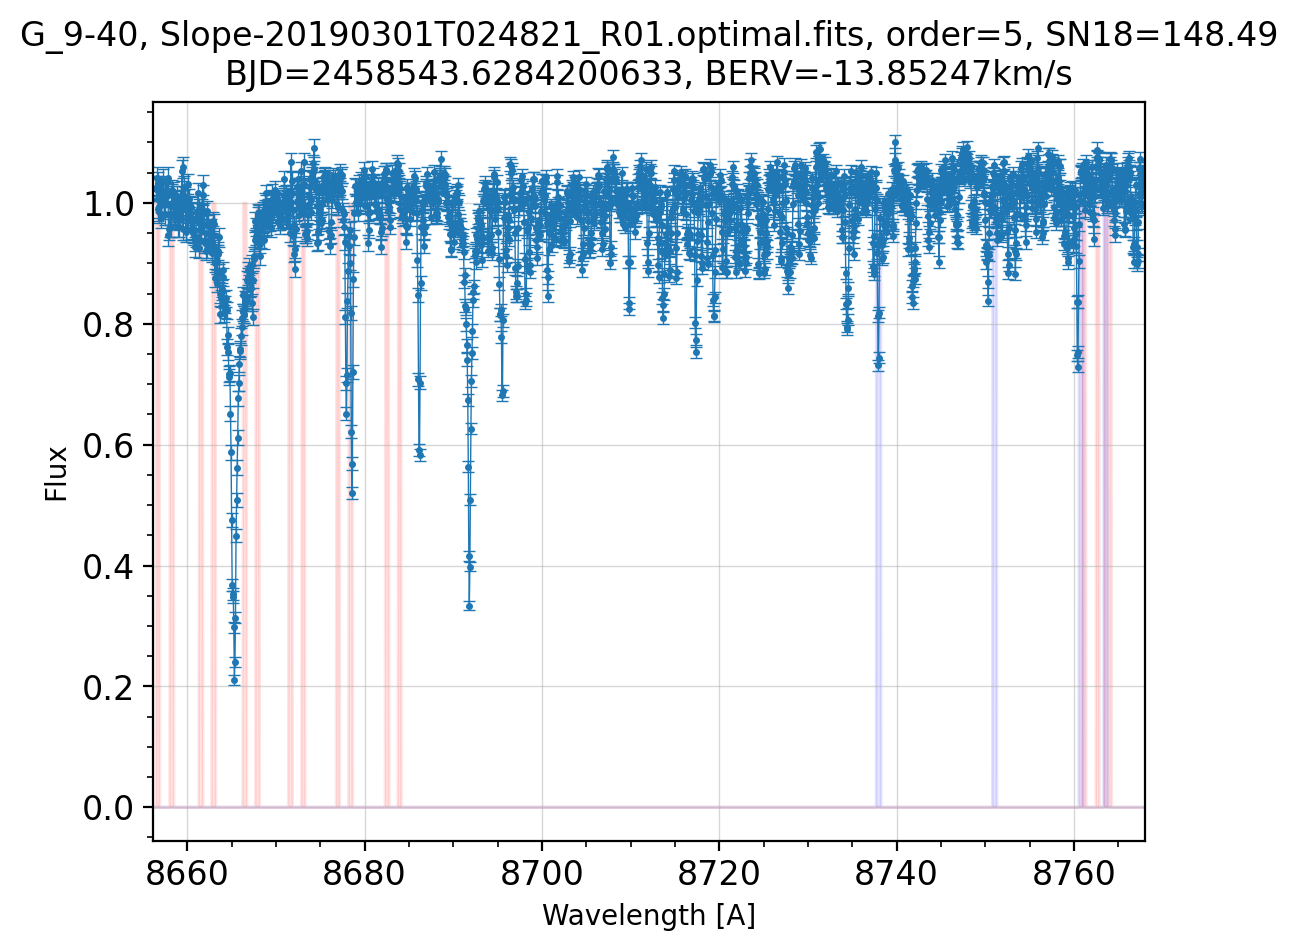

In [14]:
H.plot_order(5,deblazed=True)

Text(0.5, 1.0, 'Blazed spectrum shifted to stellar restframe\n(corrected for barycentric and absolute RV motion)')

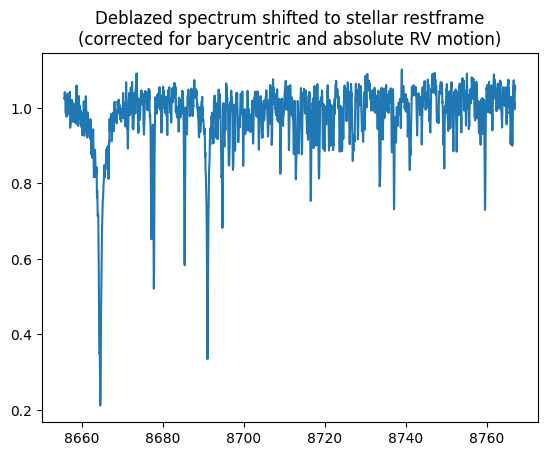

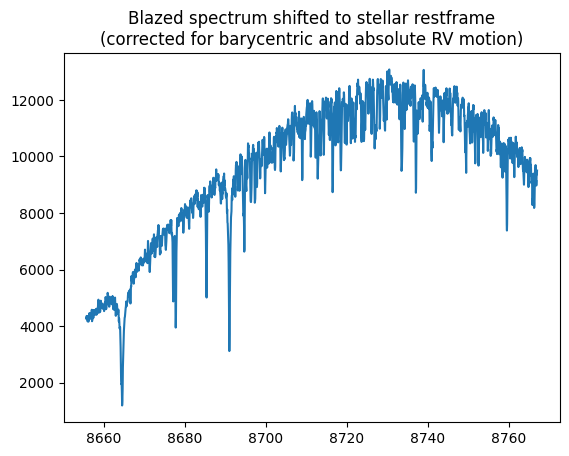

In [15]:
#We could also this this the following way using the handy wavelength and flux attributes
o = 5

# Deblazed
fig, ax = plt.subplots()
ax.plot(H.w_shifted[o],H.f_debl[o])
ax.set_title("Deblazed spectrum shifted to stellar restframe\n(corrected for barycentric and absolute RV motion)")

# Blazed
fig, ax = plt.subplots()
ax.plot(H.w_shifted[o],H.f[o])
ax.set_title("Blazed spectrum shifted to stellar restframe\n(corrected for barycentric and absolute RV motion)")

In [16]:
# Other attributes are:
print(H.w_shifted.shape) # shifted wavelength
print(H.w.shape)         # non-shifted original wavelength
print(H.f.shape)         # non-deblazed science flux (sky-subtracted)
print(H.f_debl.shape)    # deblazed science flux (sky-subtracted)
print(H.f_sci.shape)     # Science flux (not sky-subtracted)
print(H.e.shape)         # error for deblazed sky-subtracted science flux
print(H.object)          # Object
print(H.bjd)             # BJD_TDB midpoint
print(H.sn18)            # SNR for order 18
print(H.berv)            # barycentric correction in km/s

(28, 2048)
(28, 2048)
(28, 2048)
(28, 2048)
(28, 2048)
(28, 2048)
G_9-40
2458543.6284200633
148.48712
-13.852473745058003


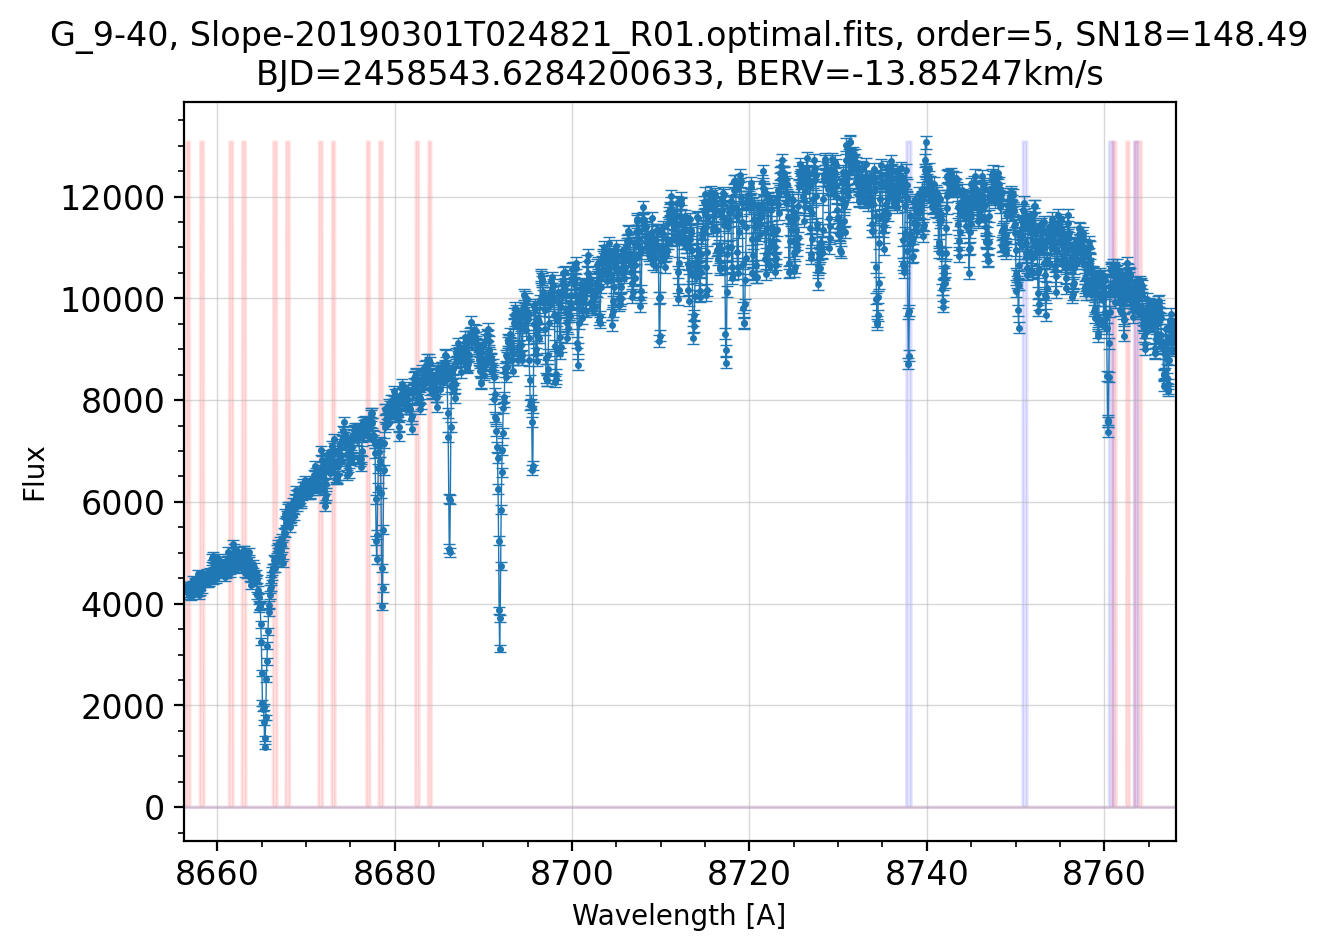

In [17]:
H.plot_order(5,deblazed=False)

# CCFs

unexpected array size: new_size=1, got array with arr_size=0

unexpected array size: new_size=1, got array with arr_size=0

unexpected array size: new_size=1, got array with arr_size=0


/home/tehan/PycharmProjects/neidspec/crosscorr/crosscorr/crosscorr.py:126: RuntimeWarning: invalid value encountered in divide
  ax.plot(v,ccf_array[o]/np.nanmax(ccf_array[o]),label="o={}".format(o))


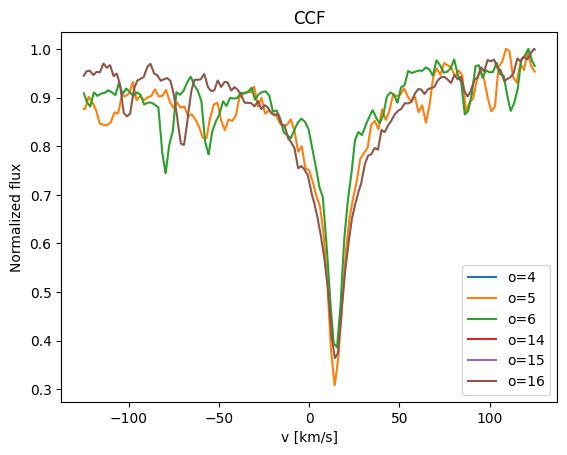

In [18]:
# Lets calculate fast ccfs for well-behaved orders using the crosscorr package
v = np.linspace(-125.,125.,1501)
orders = [4,5,6,14,15,16]
ccf = H.calculate_ccf_for_orders(v,orders=orders,plot=True)

In [19]:
# The last row in the CCF is a sum of all of the orders
ccf.shape

(29, 1501)

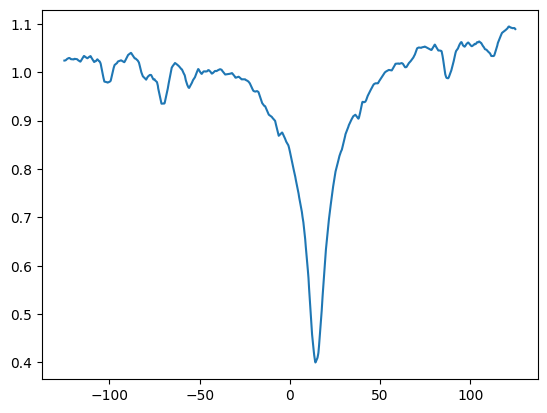

In [20]:
fig, ax = plt.subplots()
ax.plot(v,ccf[28]/np.median(ccf[28]))

# Calculate absolute RVs for orders

RVabs iteration #1: 14.33333+- 0.61237km/s
RVabs iteration #2: 14.46655+- 0.05730km/s


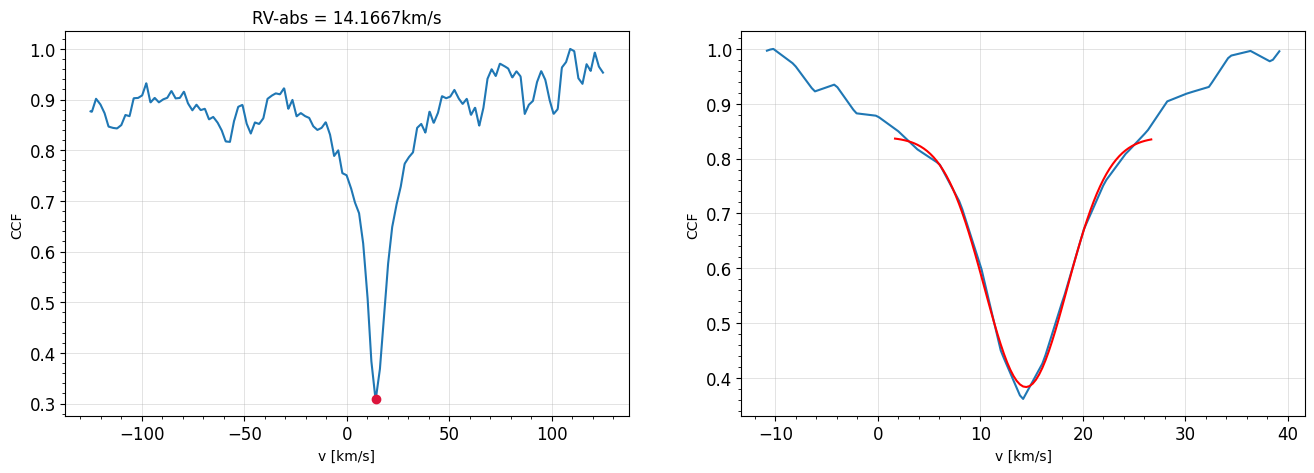

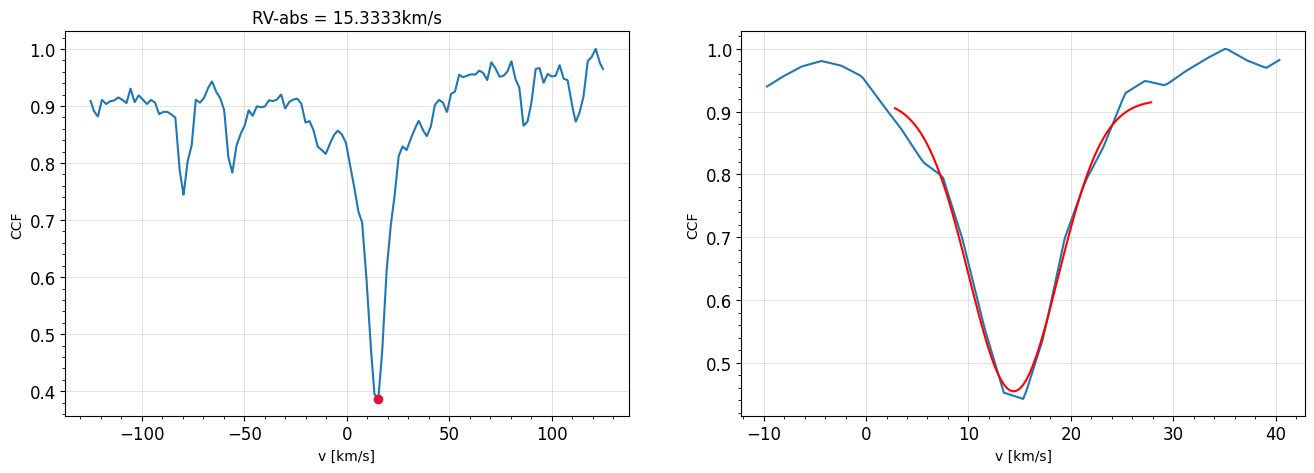

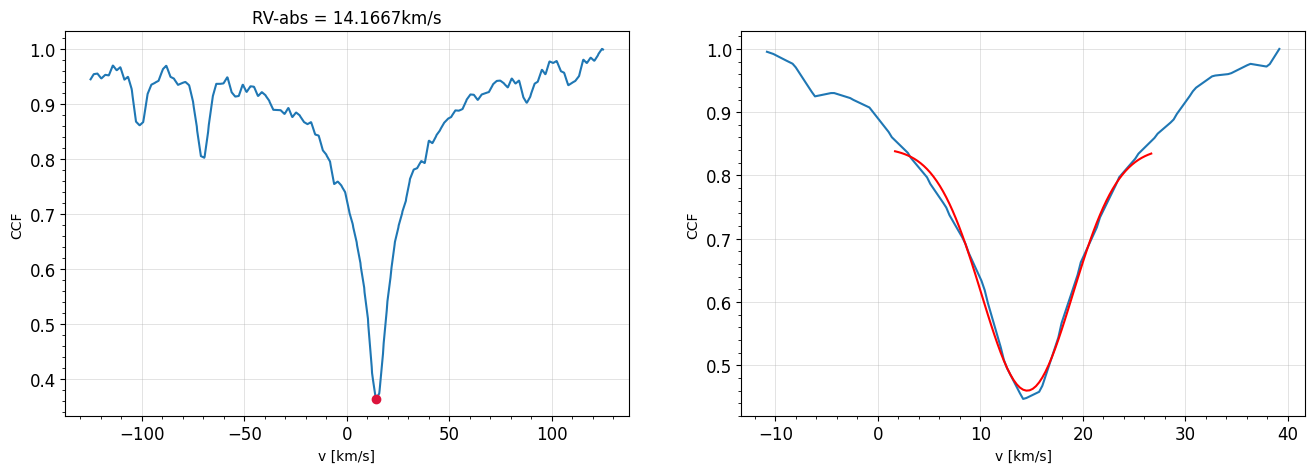

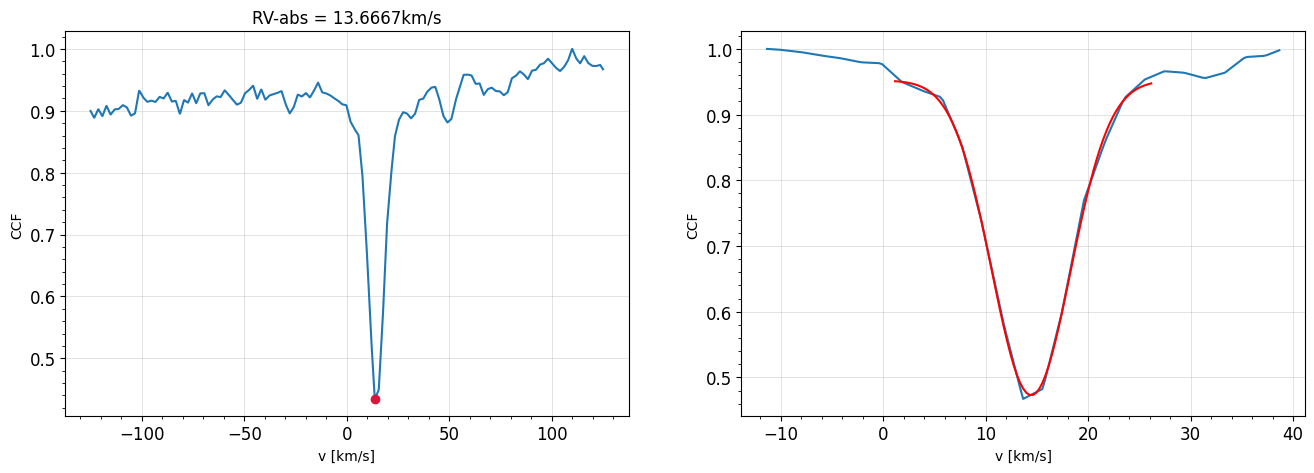

In [21]:
# Calculates on barycentric shifted (not abs RV shifted) and undeblazed version
# rv1 is just the argmin of the CCF, the rv2 is an actual Gaussian fit minimum to the CCF valley
# You can see that order 18 is pretty wonky -- likely tellurics
orders = [5,6,16,17]
rv1, rv2 = H.rvabs_for_orders(v,orders,plot=True,verbose=True)

# Working with a collection of spectra

In [22]:
import glob

In [23]:
files = glob.glob("../hpfspec/data/hpf/spectra/**/*.fits")
HS = hpfspec.HPFSpecList(filelist=files)

In [24]:
HS.df

,OBJECT_ID,filename,exptime,sn18,qprog,rv
0,G_9-40,../hpfspec/data/hpf/spectra/G_9-40/Slope-20190...,969.15,148.487122,PSU19-1-013,14.448415
1,GJ_699,../hpfspec/data/hpf/spectra/GJ_699/Slope-20181...,330.15,763.721741,ENG18-3-003,-110.552039
2,GJ_699,../hpfspec/data/hpf/spectra/GJ_699/Slope-20190...,191.70,516.510254,ENG19-1-003,-110.561023
3,G_227-22,../hpfspec/data/hpf/spectra/G_227-22/Slope-201...,585.75,173.335419,ENG18-3-003,-1.345170


In [25]:
HS.sn18

[148.48712, 763.72174, 516.51025, 173.33542]

In [26]:
HS.objects

['G_9-40', 'GJ_699', 'GJ_699', 'G_227-22']

In [27]:
H

HPFSpec(G_9-40,sn18=148.5)